# How does Twitter Discuss Trans People?

Introduction section

Mention algorithms, technologies, etc. We will use LDA, w2v, etc.

## Data engineering

### Scraping

This data was collected using [Twarc](https://github.com/DocNow/twarc), a command-line tool for scraping data from Twitter. We used the following bash command:

```sh
twarc --recursive search '"transgender" OR "trans person" OR "trans people" OR "transmasc" OR "transfem" OR "trans man" OR "trans woman" OR "trans boy" OR "trans girl" OR "trans men" OR "trans women" OR "enby" OR "non binary"' | tee /dev/tty | gzip --stdout > $OUTFILE
```

This command does the following things:
1. Searches for every tweet from the past week that contains the specified terms.
2. Prints it to console for easier reading.
3. Gzips the data to reduce disk space
4. Saves the data to wherever `$OUTFILE` is.

### Combining the data

Now, we will combine all the data into a single dataframe. 

In [1]:
import pickle
import sys
import os

import gzip
from datetime import datetime

import jsonlines
import pandas as pd

def autopickle(path):
    """
    This is a decorator to aid in pickling important things.
    
    If a file exists at the path, then this will load that gzipped pickle object.
    Otherwise, it will run the function, pickle and gzip the result, and return the function.
    """
    def decorator(func):
        if os.path.exists(path):
            with gzip.open(path, 'rb') as file:
                model = pickle.load(file)
        else:
            model = func()
            with gzip.open(path, 'wb') as file:
                pickle.dump(model, file)
        return model
    return decorator


def parse_twitter_datetime(dt: str):
    return datetime.strptime(dt, '%a %b %d %H:%M:%S +0000 %Y')


def read_jsonl_gz(path):
    with jsonlines.Reader(gzip.open(path)) as reader:
        raw_politician_tweets = list(reader)

    tweet_df = pd.DataFrame(data={
        'tweet': [t['full_text'] for t in raw_politician_tweets],
        'author': [t['user']['screen_name'] for t in raw_politician_tweets],
        'date': [parse_twitter_datetime(t['created_at']) for t in raw_politician_tweets],
        'id': [t['id'] for t in raw_politician_tweets]
    })
    tweet_df.set_index('id')

    return tweet_df

In [2]:
@autopickle('../data/joined_tweets.pickle.gz')
def tweet_df():
    INPUTS = [
        '../data/transgender/2021-05-06_2021-05-13.jsonl.gz',
        '../data/transgender/2021-05-12_2021-05-20.jsonl.gz',
    ]
    # Read all the JSONL dataframes
    dfs = [read_jsonl_gz(path) for path in INPUTS]
    
    # Concatenate the dataframes
    df = pd.concat(dfs)
    
    # Drop duplicate tweets
    df.drop_duplicates('id', inplace=True)
    return df

tweet_df

,tweet,author,date,id
0,It really is about who has autonomy over their...,POLITICOLive,2021-05-13 17:30:52,1392895129304932359
1,RT @NationalNOW: Trans women are women. They d...,GurlSlug,2021-05-13 17:30:49,1392895118521294852
2,RT @redmayseattle: TOMORROW! 11am pt. Join @so...,migrated_crane,2021-05-13 17:30:48,1392895115610447878
3,"RT @HRC: ""I don’t know how to raise my child i...",Hedge5280,2021-05-13 17:30:47,1392895109071613953
4,RT @redmayseattle: LIVE IN 30 MINUTES! @social...,socialrepro,2021-05-13 17:30:44,1392895097965060098
...,...,...,...,...
355628,But yeah it's really jarring to be having a ca...,thornhawthorne,2021-05-13 03:22:59,1392681752834019329
355652,It's weird to me how so many people just stop ...,thornhawthorne,2021-05-13 03:21:48,1392681455894073345
355848,I’m 1k away from 100k on TikTok. When i get to...,tmkenzco,2021-05-13 00:46:26,1392642356852281348
355860,RT @sciam: The first gender affirmation surger...,MsSamanthaHyde,2021-05-13 00:35:43,1392639659138854919


## Exploratory Data Analysis

### Tweet Frequency

It seems that tweets are produced cyclically, with peaks following a fairly consistent period, likely following a 24-hour cycle.

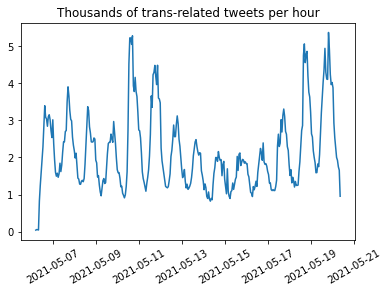

In [3]:
import matplotlib.pyplot as plt

tweets_per_hour = tweet_df.set_index('date')['tweet'].resample('1H').count() / 1000
plt.plot(tweets_per_hour)
plt.xticks(rotation=30)
plt.title('Thousands of trans-related tweets per hour')
plt.show()

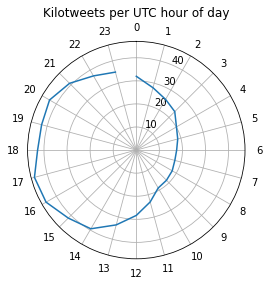

In [4]:
import numpy as np

thousands_sum_tweets_per_hour = tweet_df['date'].groupby(tweet_df['date'].dt.hour).count() / 1000
thousands_sum_tweets_per_hour.index /= 2 * np.pi
theta = np.linspace(0, 2*np.pi, 24, endpoint=False)

ax_hour = plt.subplot(111, projection='polar')
ax_hour.plot(theta, thousands_sum_tweets_per_hour)

ax_hour.set_xticks(theta)
ax_hour.set_theta_direction(-1)
ax_hour.set_xticklabels(range(24))
ax_hour.set_theta_zero_location("N")
ax_hour.set_title('Kilotweets per UTC hour of day')

plt.show()

The most tweets are written between 14:00-21:00 UTC, which corresponds to 9:00AM-4:00PM CST. This indicates a correlation between when Americans are active and activity on this subject. It could be because Americans have more to say on it, but it could also just be that Twitter in general gets more activity from Americans.

### Retweets

What percentage of tweets are retweets? This is a very primitive way of grabbing this number, but it works.

In [5]:
rt_count = len(tweet_df[tweet_df['tweet'].str.startswith('RT @')])
rt_count / len(tweet_df)

0.6655255528472397

A whopping 2/3 of these tweets are retweets! 

### Common phrases
What are the most common phrases in this document? First, we will tokenize the corpus and remove its stopwords.

In [6]:
import string
import nltk


nltk.download('stopwords')
nltk.download('wordnet')

# Build stopword set
def build_standard_stopword_set():
    stopwords = set()
    stopwords.update(nltk.corpus.stopwords.words('english'))
    stopwords.update(nltk.corpus.stopwords.words('spanish'))
    stopwords.update(string.punctuation)

    # Some twitter-specific ones
    stopwords.update(['rt', '…', '—', 'u'])
    return stopwords

standard_stopwords = build_standard_stopword_set()

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/astrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
import nltk
from collections import defaultdict

TOKEN_PERMITTED_CHARS = set('#@')


def is_token(token: str, stopwords):
    return all((
        c.isalnum() or c in TOKEN_PERMITTED_CHARS
        for c in token
    )) and token not in stopwords


tokenizer = nltk.TweetTokenizer(strip_handles=True, reduce_len=True)
lemmatizer = nltk.WordNetLemmatizer()


def tokenize_tweet(tweet, stopwords=standard_stopwords):
    """Given a tweet and a set of stopwords, converts the tweet into tokens."""
    tokens = (tok.lower() for tok in tokenizer.tokenize(tweet))
    lemmatized = (
        lemmatizer.lemmatize(tok)
        for tok in tokens
    )
    filtered = (
        tok for tok in lemmatized
        if is_token(tok, stopwords)
    )

    return list(filtered)

Now, let's plot the most common n-grams in this corpus. Because 700,000 tweets is a very large number, we will only do it on 20,000 tweets.

In [8]:
def calculate_word_freqs(series, stop, ngram_size=1):
    flat_ngrams = (
        ' '.join(ngram) 
        for doc in series
        for ngram in nltk.ngrams(tokenize_tweet(doc, stop), ngram_size)
    )
    
    ngrams = pd.Series(flat_ngrams)
            
    frequencies = ngrams.value_counts()
    frequencies.sort_values(inplace=True, ascending=False)
    return frequencies

def plot_frequencies(ax: plt.Axes, freq_series, top_count=30):
    top_n = freq_series.iloc[:top_count]
    index = [
        f'{i + 1}: {word}'
        for i, word in enumerate(top_n.index)
    ]
    ax.barh(index, top_n)
    ax.invert_yaxis()


def plot_ngrams(ax, tweet_series, stop, ngram_size=1, top_count=50):
    frequency = calculate_word_freqs(tweet_series, stop, ngram_size=ngram_size)
    plot_frequencies(ax, frequency, top_count=top_count)
    gram_label = f'{ngram_size}-gram' 
    ax.set_title(f'Top {top_count} {gram_label}s in corpus')
    ax.set_ylabel(f'{gram_label}')
    ax.set_xlabel(f'Number of occurences')

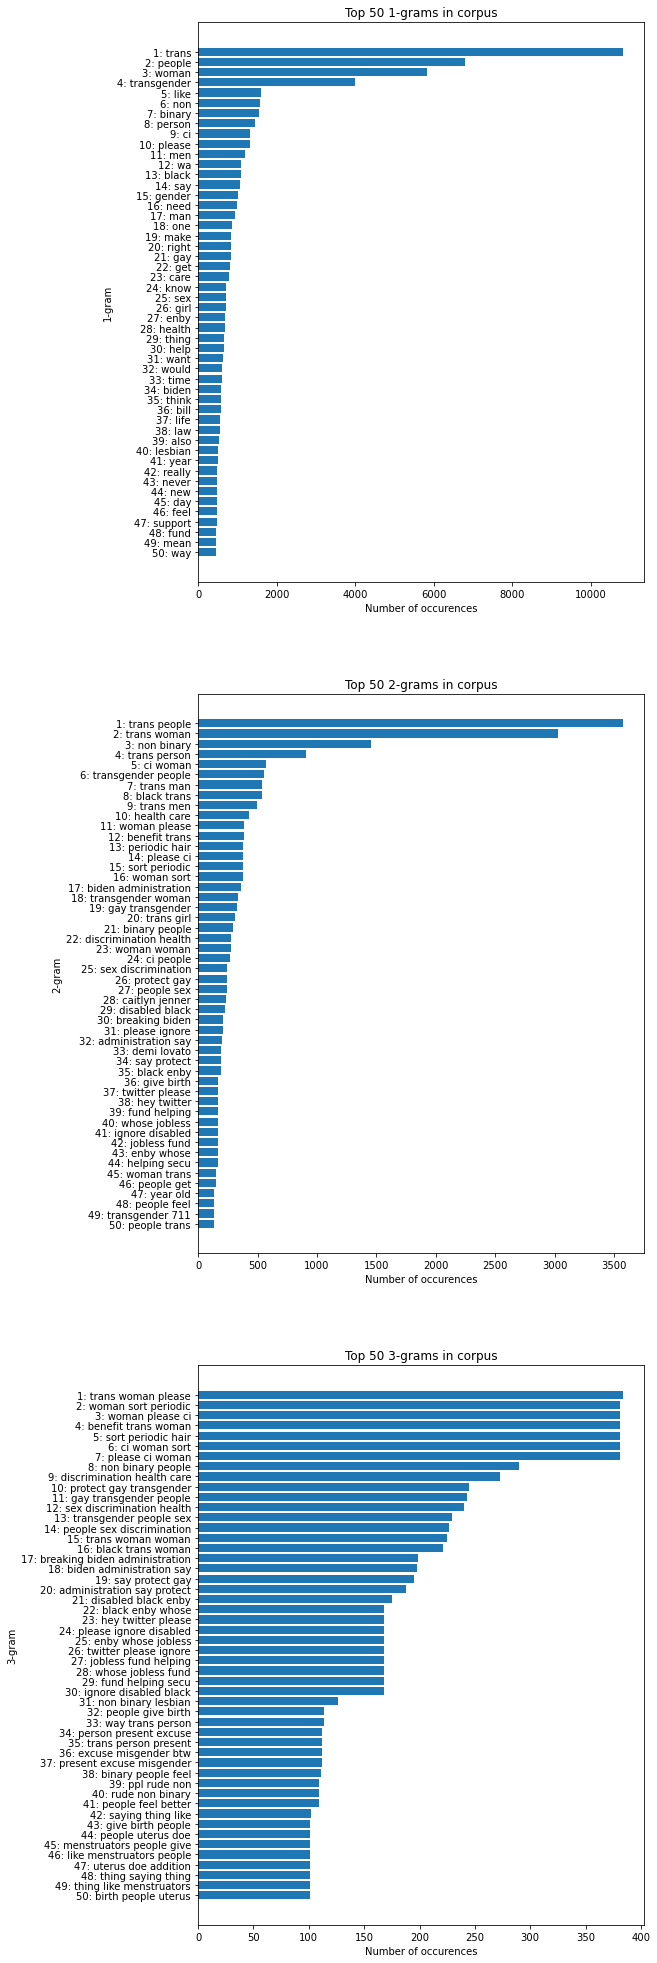

In [9]:
ngram_tweet_sample = tweet_df.sample(20_000, random_state=0)
_, axs = plt.subplots(3, 1, figsize=(8, 35))

for i, ax in enumerate(axs.flatten()):
    ngram_size = i + 1
    plot_ngrams(ax, ngram_tweet_sample['tweet'], standard_stopwords, ngram_size=ngram_size)
plt.show()

#### Observations from n-gram analysis

Some interesting results have popped up already.

- In 1-grams, `trans`, `people`, and `transgender` unsurprisingly show up a lot of times. But interestingly, in the 2-grams, `trans woman` is twice as common as `non binary`, which itself is almost three times as common as `trans man`. Trans women seem to receive the most attention, as usual.
- `black trans`, `black enby`, and `disabled black` show up a lot, as well, indicating an emphasis on intersectionality.
- On May 10, the [Biden administration declared it would enforce transgender healtcare protections](https://www.cnn.com/2021/05/10/politics/hhs-transgender-healthcare-protections-biden-administration/index.html), which is why mentions of biden show up a lot.
- There is mention of Caitlyn Jenner (2-gram #26), who has recently announced her run for the California governorship. When this was run on older data (between 2021-04-20 and 2021-04-27) she popped up a lot more often.
- Demi Lovato (2-gram #40) came out as nonbinary a few days ago.

You'll notice that stopword filtering and lemmatization have produced some interesting artifacts:
- The 26th 3-gram `trans woman woman` shows up a lot. This is likely "trans women are women," but "are" got chopped off. 
- `ci` shows up a lot. This likely doesn't mean "continuous integration," but rather "cis" as in "cisgender" being mistakenly assumed as a plural or possessive by the lemmatizer.

See [Appendix A](#appendix-a) for this same n-gram analysis done on a dataset of past data.

#### The retweet problem

There are a few limitations that have popped up with raising the n-gram length, however. You may notice some very large blocks of similar counts and similar words in 3-grams, like 1-6 or 10-19. These are tweets that have been retweeted a lot of times. Although it is not included in this notebook, this phenomenon gets worse with 4-grams. See the following cells for the corresponding tweets.

In [10]:
def tweets_containing_ngram(ngram):
    n = len(ngram)
    mask = (
        ngram_tweet_sample['tweet']
            .map(lambda t: ngram in nltk.ngrams(tokenize_tweet(t), n))
    )
    return ngram_tweet_sample[mask]

[@retronouns](https://twitter.com/retronouns/status/1391924254543912960), 15.8k retweets:

> for the benefit of all the trans women out there, please RT this if you're a cis woman and do some sort of periodic hair removal on your face

In [11]:
tweets_containing_ngram(('trans', 'woman', 'please'))

,tweet,author,date,id
83439,RT @retronouns: for the benefit of all the tra...,chia_patel,2021-05-11 22:39:28,1392248017017659392
76987,RT @retronouns: for the benefit of all the tra...,semah_baset,2021-05-12 00:27:57,1392275315364335631
116884,RT @retronouns: for the benefit of all the tra...,Nose_TurntUp,2021-05-11 14:24:28,1392123443626139649
78826,RT @retronouns: for the benefit of all the tra...,LoveWillThaw_13,2021-05-11 23:55:55,1392267255828738049
79911,RT @retronouns: for the benefit of all the tra...,greatbrittani,2021-05-11 23:37:31,1392262624675602437
...,...,...,...,...
107638,RT @retronouns: for the benefit of all the tra...,gomer2323,2021-05-11 16:52:19,1392160653687726087
113681,RT @retronouns: for the benefit of all the tra...,lauracb88,2021-05-11 15:19:26,1392137277053222913
99254,RT @retronouns: for the benefit of all the tra...,Payton_Ems,2021-05-11 18:47:19,1392189593156456449
89240,RT @retronouns: for the benefit of all the tra...,MysteryCorgi,2021-05-11 21:13:02,1392226263524429825


This tweet appears to no longer exist on Twitter, but here is a related tweet from the same person.

[@enbymilesmiles](https://twitter.com/enbymilesmiles/status/1390773557072863233), 362 retweets: 
> URGENT PLEASE READ
> 
> I’ve been jobless and these funds have been helping me secure my survival since. I’m raising funds for rent assistance and for top surgery. Please at least retweet if you see this. Thank you to all who help and have helped. My life is to you.

In [12]:
tweets_containing_ngram(('enby', 'whose', 'jobless'))

,tweet,author,date,id
119853,RT @enbymilesmiles: hey Twitter please don't i...,kai_o_0,2021-05-11 13:31:02,1392109997685886979
69831,RT @enbymilesmiles: hey Twitter please don't i...,bangtansoobin,2021-05-12 03:40:52,1392323864659513347
45319,RT @enbymilesmiles: hey Twitter please don't i...,PlannetteD,2021-05-12 17:25:54,1392531492719390720
101129,RT @enbymilesmiles: hey Twitter please don't i...,JMan4002,2021-05-11 18:23:04,1392183490834227213
67330,RT @enbymilesmiles: hey Twitter please don't i...,moonlightlexie,2021-05-12 05:13:19,1392347131688718336
...,...,...,...,...
50060,RT @enbymilesmiles: hey Twitter please don't i...,fibromiteready1,2021-05-12 15:35:38,1392503743866884096
73949,RT @enbymilesmiles: hey Twitter please don't i...,NoleDotJpg,2021-05-12 01:30:14,1392290991973965826
68097,RT @enbymilesmiles: hey Twitter please don't i...,TVdinners1111,2021-05-12 04:41:56,1392339232761384961
71606,RT @enbymilesmiles: hey Twitter please don't i...,ulteunbixx,2021-05-12 02:37:51,1392308006814060547


To deal with this, we *could* remove every retweet from the dataset. However, in doing so, it might become less representative of the weight of different topics in the dataset as a whole. So, we will simply leave them in.

## Topic Modeling

Now, we will do some unsupervised learning and classification to see if we can pry apart different topics from this dataset.

First, we will train a TF-IDF vectorizer on our full dataset.

In [17]:
import gensim

tokenized = [tokenize_tweet(tweet) for tweet in tweet_df['tweet']]
dictionary = gensim.corpora.Dictionary(tokenized)

/home/astrid/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [18]:
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized]

@autopickle('../models/final-vectorizer.pickle.gz')
def vectorizer():
    return gensim.models.TfidfModel(bow_corpus)

In [22]:
def get_vectorization(tweets):
    bow = [dictionary.doc2bow(tokenize_tweet(tweet)) for tweet in tweets]
    return vectorizer[bow]

tweet = tweet_df['tweet'].iloc[100]
print('Tweet: ', tweet)
get_vectorization([tweet])[0]

Tweet:  RT @oikusa: why is he dressed like the non binary flag https://t.co/hbwAxcaH4b


[(71, 0.25341060653498937),
 (137, 0.2542653678622533),
 (138, 0.7115967050493274),
 (139, 0.5487189306818934),
 (140, 0.25232885620892)]

Then, we will train a baseline LDA model on a sample of 30k tweets to see what insights can be gained from it.

In [57]:
def train_sample_lda(n_topics, corpus):
    return gensim.models.LdaMulticore(
        corpus=corpus,
        num_topics=n_topics,
        id2word=dictionary,
        passes=int(n_topics + 5),
        random_state=0,
    )

def tokenize_and_vectorize(texts):
    tokenization = [tokenize_tweet(tweet) for tweet in texts]
    vectorization = vectorizer[[dictionary.doc2bow(tweet) for tweet in tokenization]]
    return tokenization, vectorization

sample_corpus = tweet_df['tweet'].sample(30_000, random_state=0)
sample_corpus_tokenization, sample_corpus_vectorization = tokenize_and_vectorize(sample_corpus)

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
@autopickle('../models/final-sample-lda.pickle.gz')
def sample_lda():
    return train_sample_lda(15, sample_corpus_vectorization)

In [25]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

def get_umass_coherence(model, vec_corpus):
    cm = gensim.models.CoherenceModel(corpus=vec_corpus, model=model, dictionary=dictionary, coherence='u_mass')
    return cm.get_coherence()

def get_cv_coherence(model, vec_corpus, tokenized):
    cm = gensim.models.CoherenceModel(model=model, texts=tokenized, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()

print(f'UMass Coherence: {get_umass_coherence(sample_lda, sample_corpus_vectorization)}')
print(f'CV Coherence: {get_cv_coherence(sample_lda, sample_corpus_vectorization, sample_corpus_tokenization)}')
print(f'Log Perplexity: {sample_lda.log_perplexity(sample_corpus_vectorization)}')

pyLDAvis.gensim_models.prepare(sample_lda, sample_corpus_vectorization, dictionary)

UMass Coherence: -7.649229582507363
CV Coherence: 0.3020500745737076
Log Perplexity: -11.014148154868936


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.132375 -0.079832       1        1  13.713110
12    -0.081310  0.055944       2        1  11.581136
13    -0.054363  0.037647       3        1   9.858403
14    -0.012823  0.016069       4        1   7.062340
3     -0.019929  0.005288       5        1   6.956002
11     0.004211  0.006361       6        1   6.385038
4      0.057400 -0.084685       7        1   6.308609
5      0.007906  0.009024       8        1   5.881514
1      0.004364  0.001319       9        1   5.495460
7      0.026827  0.010172      10        1   4.937752
9      0.034857  0.016209      11        1   4.789507
6      0.031076 -0.009434      12        1   4.728562
0      0.033618  0.014995      13        1   4.165882
10     0.049268 -0.000027      14        1   4.162785
8      0.051273  0.000950      15        1   3.973899, topic_info=          Term        Freq       Total Category  logprob  loglift
4620  periodic  142.000000  142.000000  Default  30.0000  30.0000
3823   benefit  142.000000  142.000000  Default  29.0000  29.0000
438       hair  143.000000  143.000000  Default  28.0000  28.0000
4156      sort  142.000000  142.000000  Default  27.0000  27.0000
48       biden   87.000000   87.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
380       fund    4.587476   75.667967  Topic15  -6.6387   0.4224
95      people    5.476551  353.068827  Topic15  -6.4615  -0.9408
23       trans    5.224815  349.679909  Topic15  -6.5086  -0.9782
705        put    3.894945   31.402627  Topic15  -6.8023   1.1382
83       black    4.078146  130.139164  Topic15  -6.7564  -0.2375

[956 rows x 6 columns], token_table=       Topic      Freq                                  Term
term                                                        
9941       5  0.781921                             #autistic
10393      8  0.790858                     #blacklivesmatter
6960       1  0.920864                          #equalityact
85922      8  0.953142                              #freeash
86745     11  0.939044                       #freepalaestine
...      ...       ...                                   ...
86964     15  0.948538          この作品はまさに政治的に正しくないので低評価になっている
86965     15  0.948586  これらのキャラクターの名前にlgbtを冷笑的に扱うニュアンスがあったから
86966     15  0.948512                             ちょっと面白いのは
86967     15  0.948566                ニューウォーリアーズの予告動画が低評価なのは
86968     15  0.948553                                言い換えると

[2783 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 13, 14, 15, 4, 12, 5, 6, 2, 8, 10, 7, 1, 11, 9])

Given a CV of 0.3, [this indicates that our model is relatively bad](https://stackoverflow.com/questions/54762690/what-is-the-meaning-of-coherence-score-0-4-is-it-good-or-bad). The UMass (-8) is also pretty bad.

**It is important to note this LDA visualization is wrong.** The topics should not be on two axes; this visualization uses Principal Coordinate Analysis (PCoA) to project these bubbles down from a very-high-dimensional space. Nevertheless, the plots are still very useful as a visualization tool.

Qualitative observations from the 15-topic sample LDA:

- Topic 1 is the following tweet from @retronouns and its retweets:
  > for the benefit of all the trans women out there, please RT this if you're a cis woman and do some sort of periodic hair removal on your face
- Topic 7 includes mentions of Biden's executive order on transgender healthcare discrimination.
- Caitlyn Jenner is mixed into several topics (5, 2, and 7 are the most prominent).
- The clustering in the top right quadrant indicates those topics are relatively similar to each other. On closer inspection. This implies that we did not choose a good number of topics.

Note that pyLDAvis numbers topics by prominence rather than by the assignments assigned internally by Gensim's LDA. Biden's topic here seems to be 4, not 6. The tweet about periodic hair removal seems to be topic 2.

In [22]:
for i, topic in sample_lda.print_topics():
    print(f'{i}: {topic}')

0: 0.005*"binary" + 0.004*"non" + 0.002*"ideology" + 0.002*"quiet" + 0.002*"critical" + 0.002*"yes" + 0.002*"affect" + 0.002*"talk" + 0.002*"girl" + 0.002*"negatively"
1: 0.007*"thing" + 0.006*"birth" + 0.005*"give" + 0.005*"people" + 0.004*"uterus" + 0.004*"menstruators" + 0.004*"addition" + 0.004*"saying" + 0.004*"doe" + 0.003*"like"
2: 0.018*"woman" + 0.013*"ci" + 0.012*"periodic" + 0.012*"benefit" + 0.012*"hair" + 0.012*"sort" + 0.012*"please" + 0.010*"trans" + 0.008*"people" + 0.004*"need"
3: 0.004*"men" + 0.004*"woman" + 0.004*"trans" + 0.003*"leave" + 0.003*"people" + 0.002*"shitty" + 0.002*"wrong" + 0.002*"hateful" + 0.002*"rowling" + 0.002*"caitlyn"
4: 0.014*"health" + 0.014*"biden" + 0.013*"transgender" + 0.012*"administration" + 0.011*"care" + 0.010*"discrimination" + 0.010*"protect" + 0.009*"gay" + 0.009*"breaking" + 0.008*"sex"
5: 0.005*"transfem" + 0.004*"lesbian" + 0.003*"meme" + 0.003*"trans" + 0.003*"day" + 0.003*"woman" + 0.003*"one" + 0.002*"non" + 0.002*"binary" + 0

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def build_topic_df(lda, text, vectors):
    print(len(vectors))
    df = pd.DataFrame({'text': text})
    # an array of i_text -> i_topic -> score
    topic_scores = []
    for topic in lda[vectors]:
        scores = [0] * lda.num_topics
        for i, score in topic:
            scores[i] = score
    topic_scores = np.array(topic_scores, dtype=np.float32)
    
    topic_cols = list(range(lda.num_topics))
    for topic_i in topic_cols:
        df[topic_i] = topic_scores[:, topic_i]
    return df, topic_cols

build_topic_df(final_lda, date_tweet_series, vectors)

In [29]:
topic_score_df, topic_cols = build_topic_df(sample_lda, sample_corpus, sample_corpus_vectorization)
topic_score_df.head()

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
300440,@B00B1E3 mlm/nblm instead of being a pan enby :),0.706107,0.020992,0.020992,0.020992,0.020992,0.020992,0.020992,0.020992,0.020992,0.020992,0.020992,0.020992,0.020992,0.020993,0.020993
319854,RT @SpaceHunter_M: The Transgender Video Game ...,0.023226,0.023226,0.023226,0.023226,0.023226,0.023226,0.023226,0.023226,0.674841,0.023226,0.023226,0.023226,0.023226,0.023226,0.023226
109193,@Zoessielol @girlgamerfest The amount of issue...,0.014004,0.014004,0.647908,0.014004,0.014004,0.014004,0.014004,0.014004,0.014004,0.014004,0.014004,0.014004,0.170036,0.014004,0.014004
313061,RT @chasestrangio: Inclusive language around p...,0.014144,0.014144,0.014144,0.014144,0.014144,0.014144,0.014144,0.014144,0.014144,0.014144,0.014144,0.801978,0.014144,0.014144,0.014144
308804,RT @jonlis1: What does it mean to say Labour s...,0.016170,0.016170,0.773619,0.016170,0.016170,0.016170,0.016170,0.016170,0.016170,0.016170,0.016170,0.016170,0.016170,0.016170,0.016170


Here is a sampling of tweets that score high on Biden's topic (4):

In [24]:
in_topic = (topic_score_df[topic_cols] > 0.7)
pd.options.display.max_colwidth = 240
for tweet in topic_score_df['text'][in_topic[4]].sample(10, random_state=3):
    print(tweet, end='\n---\n')

Biden admin restores transgender health care protections rolled back under Trump - Axios YOU SHOULD NEVER DISCRIMINATE AGAINST ANYONE...period!!! 🌹THANK YOU PRESIDENT JOE BIDEN ❤️🇺🇸💙 https://t.co/kW0XeipQSN
---
RT @magnusllewellin: The appointment of a transgender woman and former SNP candidate to the female-only role as head of a rape crisis centr…
---
RT @AP: BREAKING: The Biden administration says the U.S. will protect gay and transgender people from sex discrimination in health care, re…
---
RT @ErinInTheMorn: Today Texas will vote as to whether or not to ban life saving medical care for transgender youth. There are a huge numbe…
---
RT @AP: BREAKING: The Biden administration says the U.S. will protect gay and transgender people from sex discrimination in health care, re…
---
RT @CeaselessSunset: Debbie is a transgender woman who moved to Los Angeles last summer to escape a toxic, abusive living situation and pur…
---
RT @Ordinary1World: And just like that president Biden restores 

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Many of these tweets do indeed mention Biden's actions. However, many do not, meaning that this topic could also have been poorly selected. This model may need to be tuned further.

### Inference experiment

How accurate does this model classify a tweet that it has never seen before? To test this, I wrote a very simple tweet that should theoretically fall into Biden's topic (4).

In [25]:
def score_text(lda, text):
    tokens = tokenize_tweet(text)
    bow = dictionary.doc2bow(tokens)
    print(tokens)
    vector = vectorizer[bow]
    return lda[vector]

score_text(sample_lda, "It's great that Biden is protecting trans healthcare!")

['great', 'biden', 'protecting', 'trans', 'healthcare']


/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.02215374),
 (1, 0.022153776),
 (2, 0.022153791),
 (3, 0.022153767),
 (4, 0.218288),
 (5, 0.02215382),
 (6, 0.4937129),
 (7, 0.022153748),
 (8, 0.022153733),
 (9, 0.022153765),
 (10, 0.022153733),
 (11, 0.022153776),
 (12, 0.02215378),
 (13, 0.022153828),
 (14, 0.02215384)]

The prediction is that the tweet fell into either 4 (22% chance) or 6 (49% chance), which correspond to the following topics:
```
4: 0.015*"biden" + 0.015*"health" + 0.013*"transgender" + 0.012*"administration" + 0.011*"care" + 0.011*"discrimination" + 0.010*"protect" + 0.009*"breaking" + 0.009*"gay" + 0.008*"sex"
6: 0.016*"711" + 0.006*"transgender" + 0.003*"woman" + 0.003*"disparity" + 0.003*"existed" + 0.003*"system" + 0.003*"particularly" + 0.003*"color" + 0.003*"face" + 0.002*"healthcare"
```
Although the tweet was supposed to fall into 4, it seems that the word "healthcare" is throwing it off and putting it in 6.

My hypothesis is that, due to retweets, the exact wording of one tweet gets duplicated across many other tweets. It seems that the highly-retweeted tweet that represents most of that category [is from @HRC with 1,747 retweets as of 2021-05-23](https://twitter.com/hrc/status/1391745293759229954):
  > BREAKING: The Biden administration will enforce federal policy to protect LGBTQ people from discrimination in health care based on gender identity & sexual orientation.
  >
  > We successfully sued the Trump admin for stripping health care protections away from LGBTQ people.

The HRC worded it as "health care," while I worded it as "healthcare." Since "healthcare" and not "health care" is what's common in topic 6, that's why it got weighted there so much.


### Hyperparameter Tuning

How many topics is enough topics? To find this out, we will train multiple models of varying `n_topics` on a sample of 20k tweets.

In [62]:
import time

hp_corpus = tweet_df['tweet'].sample(20_000, random_state=1)
hp_corpus_token, hp_corpus_vector = tokenize_and_vectorize(sample_corpus)

@autopickle('../models/final-n-topics-search.pickle.gz')
def n_topics_df():
    df = pd.DataFrame()
    df['n_topics'] = list(range(10, 50, 2))
    
    models = []
    last_time = time.time()
    for n in df['n_topics']:
        @autopickle(f'../models/intermediate-search-{n}.pickle.gz')
        def lda():
            return gensim.models.LdaMulticore(
                corpus=hp_corpus_vector,
                num_topics=n,
                id2word=dictionary,
                passes=30,
                random_state=0,
            )
        models.append(lda)
        current_time = time.time()
        dt, last_time = current_time - last_time, current_time
        print(f'Trained on n_topics={n} in {dt:.02f}s')
    
    df['model'] = models
    del models
    
    print('Finished training models, evaluating performance')

    df['coherence_umass'] = df['model'].map(lambda m: get_umass_coherence(m, sample_corpus_vectorization))
    df['coherence_cv'] = df['model'].map(lambda m: get_cv_coherence(m, sample_corpus_vectorization, sample_corpus_tokenization))
    df['log_perplexity'] = df['model'].map(lambda m: m.log_perplexity(sample_corpus_vectorization))
    
    df.set_index('n_topics', inplace=True)

    return df

n_topics_df[['coherence_umass', 'coherence_cv', 'log_perplexity']]

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coherence_umass,coherence_cv,log_perplexity
n_topics,,,
10,-9.855200,0.319046,-10.736559
12,-10.810173,0.329911,-10.902634
14,-10.777984,0.336597,-11.139141
16,-9.887761,0.327435,-11.319043
18,-10.627569,0.361552,-11.572077
20,-11.584993,0.345925,-11.966018
22,-11.228711,0.334124,-12.270138
24,-11.651593,0.351290,-12.847162
26,-11.938583,0.343114,-13.241271


Let's graph our performance with different values of `n_topics`.

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


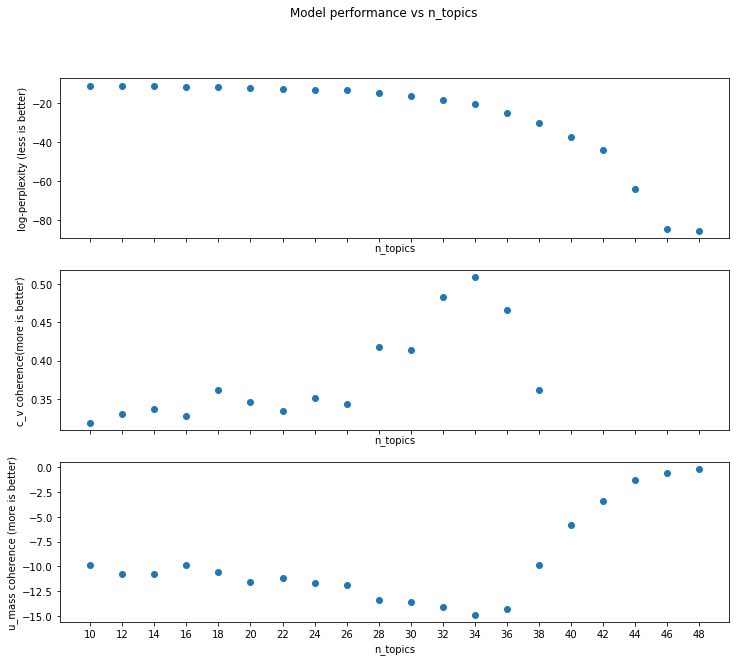

In [64]:
fig, (ax_perp, ax_cv, ax_umass) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

fig.suptitle('Model performance vs n_topics')

ax_perp.set_ylabel('log-perplexity (less is better)')
ax_cv.set_ylabel('c_v coherence(more is better)')
ax_umass.set_ylabel('u_mass coherence (more is better)')
for ax in ax_perp, ax_cv, ax_umass:
    ax.set_xlabel('n_topics')

ax_perp.set_xticks(n_topics_df.index)
ax_perp.scatter(n_topics_df.index, n_topics_df['log_perplexity'])
ax_cv.scatter(n_topics_df.index, n_topics_df['coherence_cv'])
ax_umass.scatter(n_topics_df.index, n_topics_df['coherence_umass'])

plt.show()

#### Analysis of Graphs

- **CV coherence is `NaN` past 38 topics.** This implies that those models are not very well-trained. 
  - From this, and earlier results not displayed here, the _number of passes needed to sufficiently train a topic model appears to be correlated with n_topics._
    - We are getting 38 as the last non-NaN model with 30 passes. When we had a constant 20 passes for all values of n_topics, and it produced `NaN`'s past only 36 topics, which is less than 38.
  - It could also be because those models are too big for LDA to logically handle. Most other people online seem to train on between 3 and 15 topics, rather than the 30 that I'm trying to make it train on.
- **Perplexity falls as the number of topics increases.** However, many sources say that perplexity is a bad metric to measure topic model performance on. This may be one of the reasons: _perplexity is biased towards more topics rather than fewer._
- **Oddly, CV coherence and UMass coherence appear to diverge in opinion between 26 and 38 topics.** This could be due to an insufficient number of training passes, or perhaps too many topics to even produce conclusive models. _We may want to increase the number of passes when training our full model._
  - This suggests that, if we're trying to find more specific topics, training one huge LDA on a 2-week timescale may not be the best way to go about it. It may be better to analyze smaller timeframes at a time. (see [this section for an exploration of this](#topics-over-time))
- Because we only ran this on a small sample of 20k tweets, there is a chance that some topics in the 800k were left out of our consideration. _We may want to increase the number of topics slightly for our bigger model._

#### Qualitative Analysis of Models

Any $n>38$ seems suspicious and insufficiently trained due to CV being NaN, so we will exclude those. We can look at $n=34$, the most CV-coherent model trained, with over 0.5 coherence score on it. We can additionally look at $n=10$ and $n=16$, which are the most UMass-coherent models.

##### n_topics = 34

In [65]:
pyLDAvis.gensim_models.prepare(n_topics_df['model'][34], hp_corpus_vector, dictionary)

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.298789  0.173408       1        1  12.824440
2      0.267709 -0.128099       2        1  10.795526
31     0.202372 -0.076420       3        1   7.742038
17     0.078367 -0.017884       4        1   4.663160
29     0.018722  0.006254       5        1   3.849552
6      0.005535  0.012297       6        1   3.256099
14    -0.002613  0.002948       7        1   3.147665
3     -0.004782  0.005631       8        1   3.101261
23    -0.024529  0.011956       9        1   2.855572
5     -0.020395  0.011525      10        1   2.833384
26    -0.028429  0.006531      11        1   2.688051
27    -0.008302  0.001351      12        1   2.619077
7     -0.033412  0.014462      13        1   2.555934
4     -0.013618 -0.030651      14        1   2.419070
13    -0.024983  0.003627      15        1   2.313004
15    -0.023845  0.002298      16        1   2.303402
30    -0.029340 -0.005115      17        1   2.263694
9     -0.038722  0.003720      18        1   2.210768
24    -0.038674 -0.004780      19        1   1.961150
20    -0.040719  0.004336      20        1   1.893333
11    -0.043112  0.004238      21        1   1.890967
22    -0.025957  0.004031      22        1   1.831726
8     -0.036076  0.003634      23        1   1.733061
18    -0.043050 -0.009655      24        1   1.648448
12    -0.044841 -0.000740      25        1   1.631468
21    -0.034834 -0.000684      26        1   1.600877
25    -0.042595 -0.003815      27        1   1.586223
16    -0.041005 -0.004191      28        1   1.536083
10    -0.031642  0.015286      29        1   1.466135
28    -0.041256 -0.001166      30        1   1.436642
0     -0.035771 -0.001991      31        1   1.403967
1     -0.038983  0.001405      32        1   1.359948
33    -0.040056  0.000408      33        1   1.302275
32    -0.039954 -0.004155      34        1   1.276000, topic_info=          Term        Freq       Total Category  logprob  loglift
24       woman  501.000000  501.000000  Default  30.0000  30.0000
222     please  217.000000  217.000000  Default  29.0000  29.0000
4156      sort  112.000000  112.000000  Default  28.0000  28.0000
3823   benefit  113.000000  113.000000  Default  27.0000  27.0000
438       hair  105.000000  105.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
425       tell    2.653855   50.882076  Topic34  -6.0500   1.4079
313         20    0.952260    5.701580  Topic34  -7.0749   2.5718
2056  struggle    0.644423   10.543167  Topic34  -7.4654   1.5666
1148   hormone    0.683949   16.595757  Topic34  -7.4059   1.1724
5558      took    0.677052   18.506288  Topic34  -7.4160   1.0533

[1494 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
5071      28  0.569622     #bisexual
10775     13  0.871705     #breaking
4784      26  0.525903         #enby
173       29  0.878243     #equality
6960       6  0.999106  #equalityact
...      ...       ...           ...
8687      26  0.965793            yr
3650      12  0.791891            ze
26259     13  0.850574       zealand
2784      21  0.947069          zero
2298      25  0.547070            zu

[2295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 3, 32, 18, 30, 7, 15, 4, 24, 6, 27, 28, 8, 5, 14, 16, 31, 10, 25, 21, 12, 23, 9, 19, 13, 22, 26, 17, 11, 29, 1, 2, 34, 33])

##### n_topics = 16

In [66]:
pyLDAvis.gensim_models.prepare(n_topics_df['model'][16], hp_corpus_vector, dictionary)

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.280025  0.010972       1        1  26.420330
14     0.102262  0.045171       2        1   9.416100
4      0.026708 -0.171375       3        1   7.925949
2     -0.014820  0.039283       4        1   5.974798
11    -0.013358  0.001876       5        1   5.054309
12    -0.018501  0.011723       6        1   4.915999
13    -0.025483  0.013933       7        1   4.795668
9     -0.036149  0.009713       8        1   4.491345
6     -0.017983 -0.001655       9        1   4.414445
15    -0.024139 -0.001628      10        1   4.413800
1     -0.033446  0.014353      11        1   4.151776
8     -0.046795  0.002602      12        1   3.992789
0     -0.034802  0.008001      13        1   3.645680
5     -0.043873  0.008509      14        1   3.597748
10    -0.052832  0.000122      15        1   3.456194
7     -0.046813  0.008400      16        1   3.333070, topic_info=          Term        Freq       Total Category  logprob  loglift
316         ci  184.000000  184.000000  Default  30.0000  30.0000
4620  periodic  103.000000  103.000000  Default  29.0000  29.0000
3823   benefit  103.000000  103.000000  Default  28.0000  28.0000
438       hair  104.000000  104.000000  Default  27.0000  27.0000
4156      sort  105.000000  105.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
219        man    4.657241  135.303749  Topic16  -6.4477   0.0322
23       trans    4.912969  403.702182  Topic16  -6.3943  -1.0075
1666    ignore    3.816758   47.873018  Topic16  -6.6467   0.8721
83       black    3.651728  141.480399  Topic16  -6.6909  -0.2557
909        day    3.397667   77.702320  Topic16  -6.7631   0.2715

[977 rows x 6 columns], token_table=       Topic      Freq                                  Term
term                                                        
9941      13  0.804411                             #autistic
10393     14  0.978003                     #blacklivesmatter
10775      3  1.017071                             #breaking
6960       5  0.887323                          #equalityact
85922     14  0.888264                              #freeash
...      ...       ...                                   ...
86964     12  0.990474          この作品はまさに政治的に正しくないので低評価になっている
86965     12  0.990474  これらのキャラクターの名前にlgbtを冷笑的に扱うニュアンスがあったから
86966     12  0.990474                             ちょっと面白いのは
86967     12  0.990474                ニューウォーリアーズの予告動画が低評価なのは
86968     12  0.990474                                言い換えると

[2081 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 15, 5, 3, 12, 13, 14, 10, 7, 16, 2, 9, 1, 6, 11, 8])

##### n_topics = 10

In [67]:
pyLDAvis.gensim_models.prepare(n_topics_df['model'][10], hp_corpus_vector, dictionary)

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.253443 -0.018719       1        1  34.591072
4      0.018319  0.134644       2        1  10.538403
2     -0.003501 -0.059117       3        1   8.990283
6     -0.024953 -0.005704       4        1   7.342543
8     -0.038094 -0.013368       5        1   6.994421
1     -0.044703 -0.004797       6        1   6.699708
5     -0.035477 -0.012205       7        1   6.553456
7     -0.030888 -0.012035       8        1   6.552906
9     -0.056229 -0.003831       9        1   6.169598
0     -0.037918 -0.004868      10        1   5.567610, topic_info=             Term        Freq       Total Category  logprob  loglift
4156         sort  102.000000  102.000000  Default  30.0000  30.0000
4620     periodic  100.000000  100.000000  Default  29.0000  29.0000
3823      benefit  100.000000  100.000000  Default  28.0000  28.0000
438          hair  103.000000  103.000000  Default  27.0000  27.0000
316            ci  177.000000  177.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
782          male    5.301838   61.014644  Topic10  -6.8312   0.4451
327          year    5.257183   66.751240  Topic10  -6.8396   0.3468
257   transphobic    5.125317   61.244990  Topic10  -6.8650   0.4075
210            hi    5.033412   52.192617  Topic10  -6.8831   0.5494
222        please    5.106905  165.641177  Topic10  -6.8686  -0.5910

[629 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
10393      7  0.890332  #blacklivesmatter
6960       3  0.860532       #equalityact
85922      7  0.837755           #freeash
4018       7  1.010920           #haikyuu
14325      7  0.832619          #idahobit
...      ...       ...                ...
327        8  0.179772               year
327       10  0.074905               year
1331       1  1.000332                yes
7287       9  0.731896                 yt
3650      10  0.702420                 ze

[1163 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 7, 9, 2, 6, 8, 10, 1])

The same warnings about the visualizations being wrong applies here. 

It is interesting to note that all three graphs have some very similar structure.

- There is a very significantly different topic on the right.
- On the left, most of the topics are very closely clustered.
- They even share similarities with the 15-topic baseline LDA from earlier.

Topics 10 and 16 are even more similar.

  - Their most significant topic are on the right and nearly identical, both containing "trans," "people," "woman," "men," "non," and "binary," which just so happen to be the overall topic that we are performing an analysis of right now.
  - They both have a relatively prominent Biden topic.
  - The "periodic shaving" topic is, in both cases, close to the cluster of topics. It retains its spot in n = 34, as well.
  - If you flip topic 10 in the y-axis, all of the components will basically line up with each other. 
 
Overall, it seems that LDA produces pretty stable results even as you increase the number of topics. Some further interesting observations:

- At some point, the rightmost super-topic appears to explode into multiple smaller topics, as seen in n = 34. 
- Biden's topic moves to the top right, indicating that either the basis of the PCoA projection has changed due to the topics splitting apart, or that Biden's topic used to contain more topics before splitting up.
- The topic containing GoFundMe links (5 in n = 10, 2 in n = 16, and 5 in n = 34) is within the cluster for n = 10 and n = 34, but leaves the cluster for n = 16.
  - In n = 34, topic 6, which is one of the closest ones to topic 5, has the token "gfm" in it. Given the context (mentions of american, conservative, and flag), it could mean "god forgive me." However, it may also be the short form of "go fund me."
- Demi Lovato does not get their own topic in n = 10. However, they do get it in n = 16 (topic 6) and n = 34 (topic 16). Both times, they are in a fairly similar place in terms of significance ranking.

I think it is pretty safe to train a LDA on 36 topics, based on all of the above analysis.

### Training the tuned LDA with our selected parameters

Now that we've selected a good number of topics to train, we can train an LDA on the entire dataset using it. First, let's preprocess our entire corpus.

In [ ]:
full_corpus = tweet_df.set_index('date')['tweet']  # index by date so we can do interesting things with it later
full_tokens, full_vectors = tokenize_and_vectorize(full_corpus)

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
@autopickle('../models/final-final-lda.pickle.gz')
def final_lda():
    return gensim.models.LdaMulticore(
        corpus=full_vectors,
        num_topics=24,
        id2word=dictionary,
        workers=16,
        passes=40,
        random_state=0,
    )

In [ ]:
print(f'UMass Coherence: {get_umass_coherence(final_lda, full_vectors)}')
print(f'CV Coherence: {get_cv_coherence(final_lda, full_vectors, full_tokens)}')
print(f'Log Perplexity: {final_lda.log_perplexity(full_vectors)}')

pyLDAvis.gensim_models.prepare(final_lda, full_vectors, dictionary)

## Topics over Time<a name="topics-over-time"></a>

Which topics become more dominant over time? To figure this out, we can plot a heatmap.

In [ ]:
topic_df, topic_cols = build_topic_df(final_lda, date_tweet_series, full_vectors)

In [58]:
# becomes indexed in (time, topic score)
def plot_prominence_heatmap(ax, topic_score_df, resample_period, lda_model):
    chunked_scores = topic_score_df.resample(resample_period).sum()
    _, topics_n = topics_over_time.shape

    time_normalized_topic_prominence = topics_over_time / topics_over_time.sum(axis=0, keepdims=True)  # normalize by time

    yticks = [f'({i}) {words}' for i, words in lda_model.print_topics(-1, num_words=3)]

    ax.set_title('Topic Dominance over Time')
    ax.set_xlabel('Time Periods')
    ax.set_ylabel('Topic')
    ax.set_yticks(list(range(len(yticks))))  # show every topic
    ax.set_yticklabels(yticks)
    return ax.imshow(time_normalized_topic_prominence), topics_over_time

fig, ax_heatmap = plt.subplots(1, 1, figsize=(16, 16), dpi=300)

mappable, topics_over_time = plot_prominence_heatmap(ax_heatmap, topic_df[topic_cols], '1D', final_lda)
plt.colorbar(mappable)

ax_total.set_title('Total discussion about Transgender Issues')
ax_total.plot(topics_over_time.sum(axis=0))

plt.show()

/home/astrid/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


736415


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Conclusion

The TFIDF-LDA pipeline is able to provide many interesting insights about the topics within a set of tweets. However, it does not perform very well on new information that has not been encountered before.

There are many potential avenues of further exploration for this project. 
- We could see how well different vectorizers might perform in place of TF-IDF, like Word2Vec or Doc2Vec. 
- There may be better ways to deal with retweets. We could try filtering out retweets to see how well the model performs.
- We could try feeding bigrams and trigrams into our topic model.
- Instead of tweets, what about users? Which users tweet the most on this topic? Which users interact with each other? 
- We could try to create a classifier which rates tweets as pro-trans or anti-trans.


## Appendix A: Insights from a Previous Dataset<a name="appendix-a"></a>

This following dataset was collected from tweets containing either `trans people` or `transgender` between the dates of 2021-04-20 and 2021-04-27, about 2 weeks before the dataset from above. A very large number of events happened this week, and it provides different, but just as interesting insights. 

This was not concatenated to the primary dataset for two main reasons.

1. It has different search terms. Non-binary topics are likely to be de-emphasized here.
2. It is not contiguous with the later dataset. There will be a 2-week hole of data, which will likely reduce the quality of results.

In [ ]:
@autopickle('../data/old-tweet-data.pickle.gz')
def old_tweet_df():
    PATHS = [
        '../data/search_transgender.jsonl.gz',
        '../data/search_trans_people.jsonl.gz',
    ]

    df = pd.concat([read_jsonl_gz(path) for path in PATHS])
    df.drop_duplicates('id', inplace=True)
    return df

old_tweet_df

Here is the n-gram frequency chart.

In [ ]:
ngram_tweet_sample = old_tweet_df.sample(50_000, random_state=0)
_, axs = plt.subplots(4, 1, figsize=(8, 45))

for i, ax in enumerate(axs.flatten()):
    ngram_size = i + 1
    plot_ngrams(ax, ngram_tweet_sample['tweet'], standard_stopwords, ngram_size=ngram_size)
plt.show()

- There is mention of the Myanmar coup, which attacked and abducted Mingalar Taungnyunt, a trans woman involved in the protests.
- Just as before, `trans woman` is near the top of the 2-grams, while `trans man` is nowhere to be seen. Non-binary people are not mentioned, however, 
- A mass shooting on Thursday was performed by a trans man.
- Caitlyn Jenner (2-gram #3) announced her run for governor. 
- There are mentions of the LGB alliance, a TERF (trans-exclusionary radical feminist) group.
- `go fund goal` is likely the result of `go fund me goal` after stopword removal. 
- There is mention of various bills where republicans attack trans people in women's sports, such as `florida genital inspection` or  `texas senate approved sb1646`.
- There seems to be a tweet with a large number of retweets, which listed bills in Georgia that got signed by the Governor. One of them was an anti-trans bill, the other was a running-over-protestors bill, and another made it illegal to film police. Thus, they all got lumped together.